# generation.cnn

> Fill in a module description here

In [ ]:
from monitosed.data.core import *
from monitosed.models import *
from monitosed.losses import *

%load_ext autoreload
%autoreload 2

In [ ]:
import mat73
from fastcore.xtras import Path
import pandas as pd
import numpy as np

from tsai.all import *

# Prepare Data

In [ ]:
path = Path("../_data/foot1/Rest"); path.ls()

(#14) [Path('../_data/foot1/Rest/VR23_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR20_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR26_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR31_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR27_Reststim_data_clean.mat'),Path('../_data/foot1/Rest/VR40_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR51_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR41_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR38_RestStim_data_clean.mat'),Path('../_data/foot1/Rest/VR35_RestStim_data_clean.mat')...]

## Load data

In [ ]:
mats = load_mats(path)

  0%|          | 0/14 [00:00<?, ?it/s]

Loading: VR20_Reststim_data_clean.mat
Loading: VR23_RestStim_data_clean.mat
Loading: VR26_Reststim_data_clean.mat
Loading: VR27_Reststim_data_clean.mat
Loading: VR31_Reststim_data_clean.mat
Loading: VR35_RestStim_data_clean.mat
Loading: VR38_RestStim_data_clean.mat
Loading: VR40_RestStim_data_clean.mat
Loading: VR41_RestStim_data_clean.mat
Loading: VR51_RestStim_data_clean.mat
Loading: VR52_RestStim_data_clean.mat
Loading: VR57_Reststim_data_clean.mat
Loading: VR59_Reststim_data_clean.mat
Loading: VR60_Reststim_data_clean.mat


In [ ]:
#Optional
signal_len = 500

## Get labels

The first idea is to perform forecasting, i.e. predict the future signal. To do so, we have to cut the measured signal into a past and the future we would like to predict.

/!\ the stimulus happens at 250

In [ ]:
trn_len = 300
pred_len = signal_len-trn_len
valid_pct=0.2

## DataBlock

In [ ]:
data = np.concatenate([read_data(mat) for mat in mats])
data = data[:,:,:signal_len]
data.shape

(778, 173, 500)

In [ ]:
data.shape

(778, 173, 500)

In [ ]:
#x = torch.from_numpy(data)[:,:, :trn_len]
x = torch.from_numpy(data.copy())
#y = torch.from_numpy(data)[:,:, trn_len:]
y = torch.from_numpy(data.copy())
x.shape, y.shape

(torch.Size([778, 173, 500]), torch.Size([778, 173, 500]))

In [ ]:
x[:,:,trn_len:] = torch.randn(*x[:,:,trn_len:].shape)

In [ ]:
getters = [ItemGetter(0), ItemGetter(1)]

In [ ]:
train_ix = int((1-valid_pct)*len(x))

In [ ]:
splits = (np.arange(0, train_ix), np.arange(train_ix, len(x)))

In [ ]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
dblock = DataBlock(blocks=(TSTensorBlock, TSTensorBlock),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)

source = itemify(x,y)

dls = dblock.dataloaders(source, bs=4, val_bs=8, num_workers=8)

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([4, 173, 500]), torch.Size([4, 173, 500]))

[<matplotlib.lines.Line2D>]

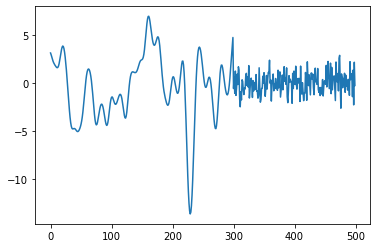

In [ ]:
plt.plot(xb[0][0].to('cpu').numpy())

<matplotlib.image.AxesImage>

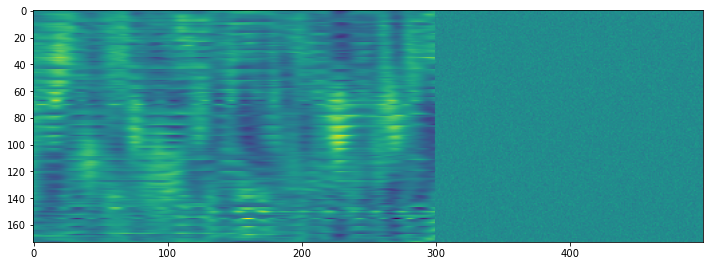

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(xb[0].to('cpu').numpy())

<matplotlib.image.AxesImage>

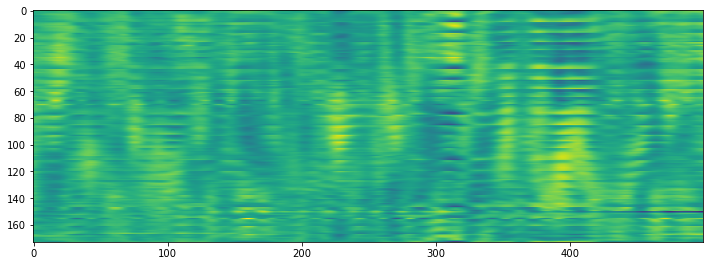

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(yb[0].to('cpu').numpy())

In [ ]:
net = StagerUNet_M(173, embed_dim=1)

In [ ]:
xb.shape

torch.Size([4, 173, 500])

In [ ]:
xout = net(xb.to('cpu'))

<matplotlib.image.AxesImage>

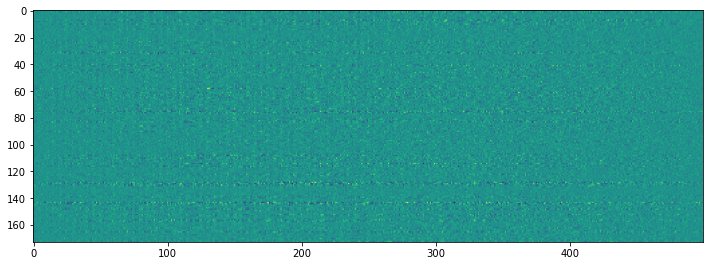

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(xout[0].to('cpu').detach().numpy())

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, size_average=None, reduce=None, alpha=0.5, reduction: str = 'mean') -> None:
        super(CustomLoss, self).__init__()
        store_attr()

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        l1 = F.l1_loss(input, target, reduction=self.reduction)
        mse = F.mse_loss(input, target, reduction=self.reduction)
        return self.alpha*l1 + (1-self.alpha)*mse

In [ ]:
learn = Learner(dls, net, loss_func=CustomLoss(), metrics=[mae, rmse], wd=1, cbs=ShowGraph())

epoch,train_loss,valid_loss,mae,_rmse,time
0,8.683238,7.330503,2.198819,3.530182,00:08
1,8.341117,7.506594,2.291394,3.566762,00:07
2,7.650790,7.379282,2.248701,3.536928,00:07
3,8.414534,7.686992,2.323935,3.612485,00:07
4,10.199923,8.658038,2.567312,3.840412,00:07
5,9.465446,8.778734,2.634310,3.863050,00:07
6,9.626359,9.003091,2.616670,3.922947,00:07
7,9.537219,9.161760,2.654912,3.958359,00:07
8,10.437703,9.203692,2.692430,3.964209,00:07
9,10.932980,9.572007,2.781928,4.045007,00:07


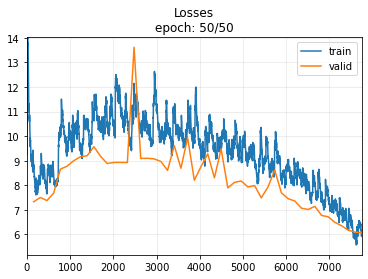

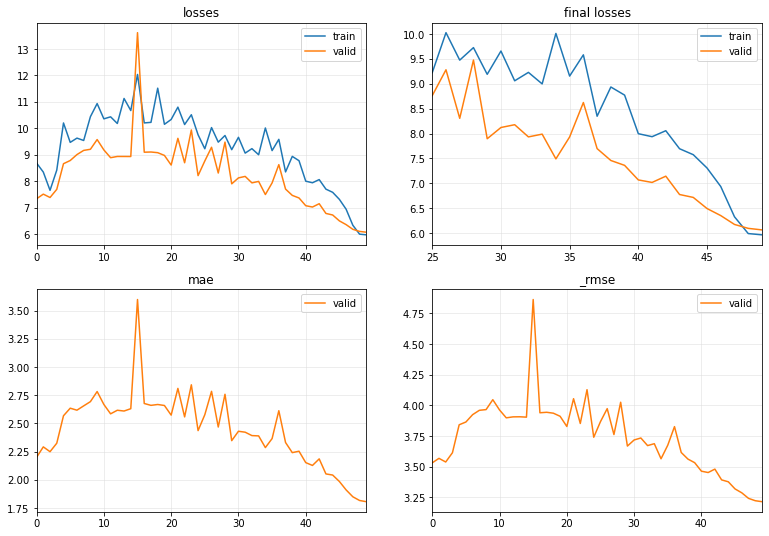

In [ ]:
learn.fit_one_cycle(50, 1e-1)

In [ ]:
in_valid, pred_valid, true_valid = learn.get_preds(with_input=True)

In [ ]:
in_valid.shape

torch.Size([156, 173, 500])

<matplotlib.image.AxesImage>

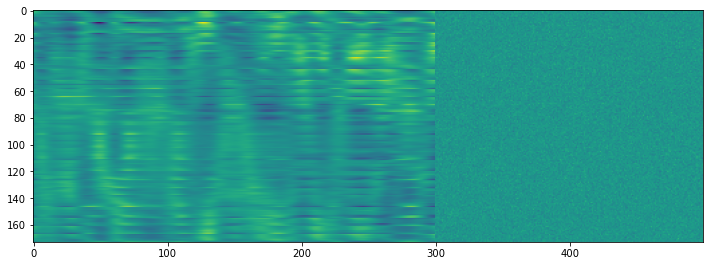

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(in_valid[1].to('cpu').detach().numpy())

<matplotlib.image.AxesImage>

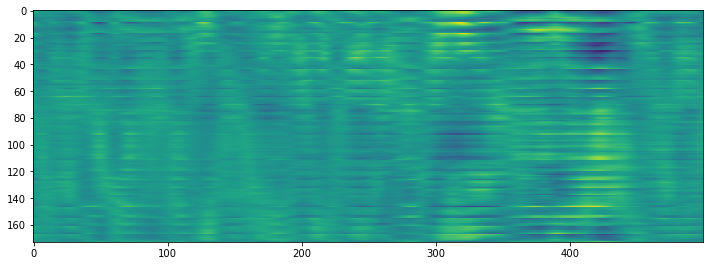

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(true_valid[1].to('cpu').detach().numpy())

<matplotlib.image.AxesImage>

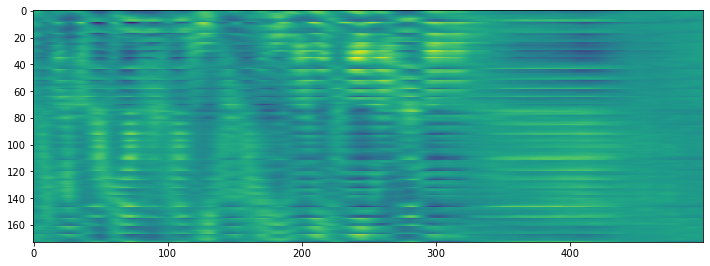

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(pred_valid[1].to('cpu').detach().numpy())

In [ ]:
trn_len = 250
pred_len = signal_len-trn_len
valid_pct=0.2

In [ ]:
data = np.concatenate([read_data(mat) for mat in mats])
data = data[:,:,:signal_len]
data.shape

(778, 173, 500)

In [ ]:
data.shape

(778, 173, 500)

In [ ]:
x = torch.from_numpy(data.copy())[:,:, :trn_len]
y = torch.from_numpy(data.copy())[:,:, trn_len:]
x.shape, y.shape

(torch.Size([778, 173, 250]), torch.Size([778, 173, 250]))

In [ ]:
#x[:,:,trn_len:] = torch.randn(*x[:,:,trn_len:].shape)

In [ ]:
getters = [ItemGetter(0), ItemGetter(1)]

In [ ]:
train_ix = int((1-valid_pct)*len(x))

In [ ]:
splits = (np.arange(0, train_ix), np.arange(train_ix, len(x)))

In [ ]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
dblock = DataBlock(blocks=(TSTensorBlock, TSTensorBlock),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)

source = itemify(x,y)

dls = dblock.dataloaders(source, bs=4, val_bs=8, num_workers=8)

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([4, 173, 250]), torch.Size([4, 173, 250]))

[<matplotlib.lines.Line2D>]

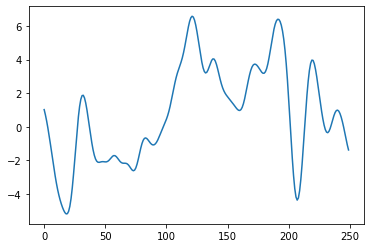

In [ ]:
plt.plot(xb[0][0].to('cpu').numpy())

<matplotlib.image.AxesImage>

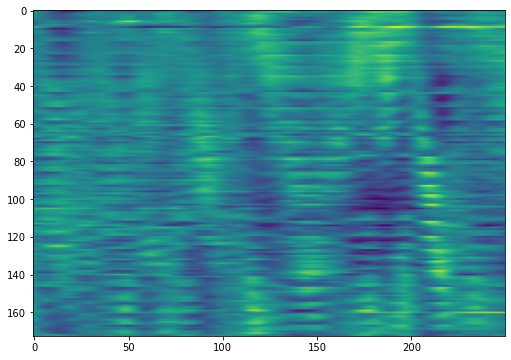

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(xb[0].to('cpu').numpy())

<matplotlib.image.AxesImage>

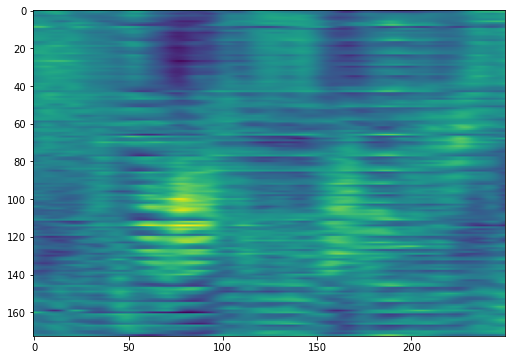

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(yb[0].to('cpu').numpy())

In [ ]:
class StagerUNet_M(nn.Module):
    def __init__(self, channels, dropout_rate=0.5, embed_dim=100, print_shape=False):
        super().__init__()
        self.conv1 = nn.Conv2d(1, channels, (channels, 1), stride=(1, 1), padding=(0, 0))
        self.conv2 = nn.Conv2d(1, 16, (1, 51), stride=(1, 1), padding=(0, 25))
        self.conv3 = nn.Conv2d(16, 16, (1, 51), stride=(1, 1), padding=(0, 25))
        self.conv4 = nn.Conv2d(16, 16, (1, 51), stride=(1, 1), padding=(0, 25))

        self.dropout_rate = dropout_rate
        self.embed_dim = embed_dim
        
        self.upconv4 = nn.Conv2d(16, 16, (1, 51), stride=(1, 1), padding=(0, 25))
        self.upconv3 = nn.Conv2d(16, 16, (1, 51), stride=(1, 1), padding=(0, 25))
        self.upconv2 = nn.Conv2d(16, 1, (1, 51), stride=(1, 1), padding=(0, 25))
        self.upconv1 = nn.Conv2d(1, channels, (channels, 1), stride=(1, 1), padding=(0, 0))
        self.upconv0 = nn.Conv2d(1, 1, (3, 5), stride=(1, 1), padding=(1, 2))

        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.batchnorm3 = nn.BatchNorm2d(16)
        
        self.upbatchnorm1 = nn.BatchNorm2d(16)
        self.upbatchnorm2 = nn.BatchNorm2d(16)
        self.upbatchnorm3 = nn.BatchNorm2d(16)
        
        self.print_shape = print_shape

    
    def forward(self, x):

        x = torch.unsqueeze(x, 1)
        
        if self.print_shape: print(x.shape)


        x = self.conv1(x)
        if self.print_shape: print(x.shape)

        x = x.permute(0, 2, 1, 3)
        if self.print_shape: print(x.shape)
        x = self.conv2(x)
        
        if self.print_shape: print(x.shape)
        x, ix1 = F.max_pool2d_with_indices(x, (1,5))
        x = F.relu(x)
        if self.print_shape: print(x.shape)
        x = self.batchnorm1(x)
        
        x = self.conv3(x)
        
        if self.print_shape: print(x.shape)
        x, ix2 = F.max_pool2d_with_indices(x, (1,5))
        x = F.relu(x)                               
        x = self.batchnorm2(x)     
        
        x = self.conv4(x)
        
        if self.print_shape: print(x.shape)
        x, ix3 = F.max_pool2d_with_indices(x, (1,5))
        x = F.relu(x)                               
        x = self.batchnorm3(x) 
        
        
        if self.print_shape: print(x.shape)
        x = F.relu(F.max_unpool2d(x, ix3, (1,5)))   
        x = self.upbatchnorm3(x)   
        if self.print_shape: print(x.shape)
        x = self.upconv4(x) 
        
        
        if self.print_shape: print(x.shape)
        x = F.relu(F.max_unpool2d(x, ix2, (1,5)))   
        x = self.upbatchnorm2(x)   
        if self.print_shape: print(x.shape)
        
        x = self.upconv3(x) 
        
        
        if self.print_shape: print(x.shape)
        
        x = F.relu(F.max_unpool2d(x, ix1, (1,5)))
        x = self.upbatchnorm1(x) 
        
        x = self.upconv2(x) 
        if self.print_shape: print(x.shape)
        
        
        x = self.upconv1(x)
        
        #x = x.permute(0, 2, 1, 3)
        if self.print_shape: print(x.shape) 
            
        #x = self.upconv0(x)
        
        x = torch.squeeze(x, 2)    
        
        if self.print_shape: print(x.shape) 
    
        
        return x

In [ ]:
net = StagerUNet_M(173, embed_dim=1, print_shape=False)

In [ ]:
xout = net(xb.to('cpu'))

<matplotlib.image.AxesImage>

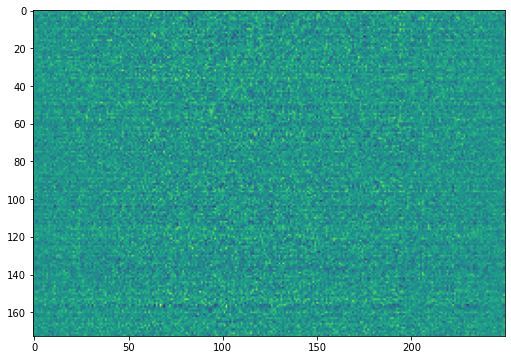

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(xout[0].to('cpu').detach().numpy())

In [ ]:
learn = Learner(dls, net, loss_func=CustomLoss(), metrics=[mae, rmse], wd=1, cbs=ShowGraph())

epoch,train_loss,valid_loss,mae,_rmse,time
0,14.659051,14.726736,3.593305,5.085289,00:05
1,214.715561,14.947932,3.607458,5.127222,00:04
2,24.290987,14.891907,3.595215,5.117479,00:05
3,16.106245,14.899280,3.596800,5.118765,00:05
4,15.731718,14.595378,3.551017,5.063570,00:04
5,15.034883,13.763484,3.423404,4.909538,00:05
6,15.084778,14.826571,3.591049,5.105104,00:05
7,14.762893,14.239727,3.496456,4.998300,00:05
8,14.111123,13.907266,3.460627,4.934968,00:05
9,13.942387,13.868322,3.448653,4.928285,00:05


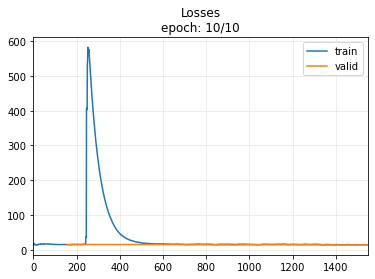

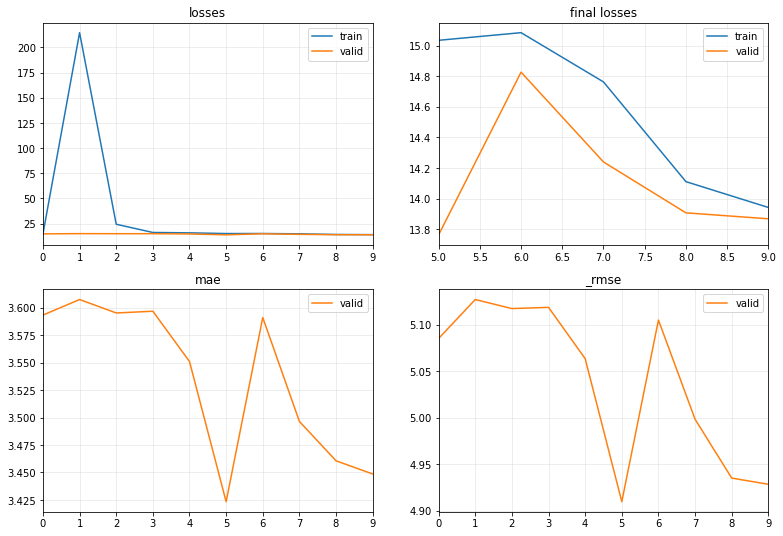

In [ ]:
learn.fit_one_cycle(10, 1e-1)

In [ ]:
in_valid, pred_valid, true_valid = learn.get_preds(with_input=True)

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(in_valid[1].to('cpu').detach().numpy())

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(true_valid[1].to('cpu').detach().numpy())

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(pred_valid[1].to('cpu').detach().numpy())

# With CNN Unet

In [ ]:
from fastai.vision.all import *

In [ ]:
x = torch.from_numpy(data.copy())
y = torch.from_numpy(data.copy())
x.shape, y.shape

(torch.Size([112, 173, 500]), torch.Size([112, 173, 500]))

In [ ]:
x[:,:,trn_len:] = torch.randn(*x[:,:,trn_len:].shape)

In [ ]:
x = x.unsqueeze(1)
y = y.unsqueeze(1)

In [ ]:
getters = [ItemGetter(0), ItemGetter(1)]

In [ ]:
train_ix = int((1-valid_pct)*len(x))

In [ ]:
splits = (np.arange(0, train_ix), np.arange(train_ix, len(x)))

In [ ]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [ ]:
dblock = DataBlock(blocks=(TSTensorBlock, TSTensorBlock),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)

source = itemify(x,y)

dls = dblock.dataloaders(source, bs=4, val_bs=8, num_workers=8)

In [ ]:
m = resnet18().to('cpu')

In [ ]:
m.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
#m = resnet34()
m = nn.Sequential(*list(m.children())[:-2])
tst = DynamicUnet(m, 1, (173,1500), norm_type=None)

In [ ]:
learn = Learner(dls, tst, loss_func=CustomLoss(), metrics=[mae, rmse], wd=1, cbs=ShowGraph())

epoch,train_loss,valid_loss,mae,_rmse,time
0,1632921190400.000000,14.143175,3.568157,4.971739,00:05
1,637947936768.000000,10.103362,3.061592,4.140668,00:04
2,327098269696.000000,8.889800,2.832117,3.866198,00:04
3,185855393792.000000,7.109853,2.375668,3.441517,00:04
4,111060287488.000000,8.583885,2.752613,3.796730,00:04
5,68233117696.000000,7.044075,2.325434,3.429682,00:04
6,42607562752.000000,13.145415,2.998188,4.826245,00:04
7,26869211136.000000,7.008402,2.302412,3.422630,00:04
8,17047899136.000000,6.239519,2.073871,3.225704,00:04
9,10857936896.000000,6.059170,2.009579,3.179428,00:04


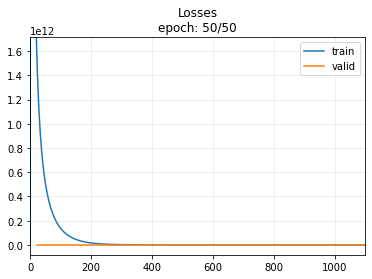

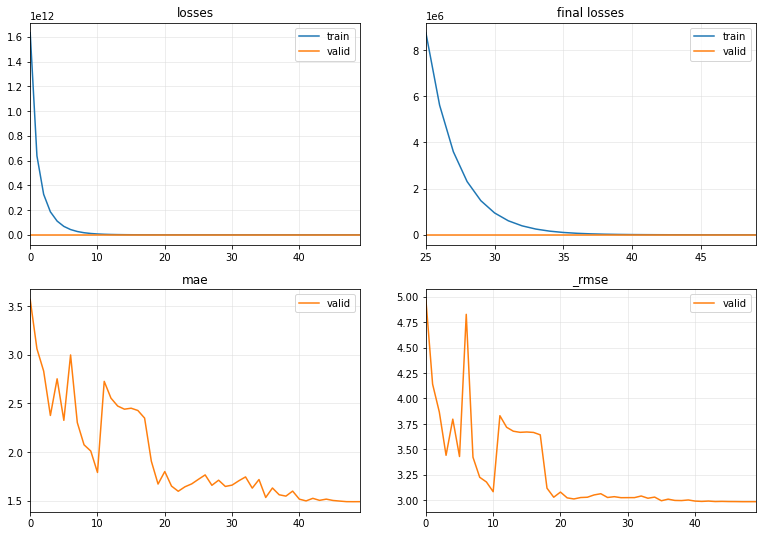

In [ ]:
learn.fit_one_cycle(50, 1e-1)

In [ ]:
in_valid, pred_valid, true_valid = learn.get_preds(with_input=True)

In [ ]:
in_valid.shape

torch.Size([23, 1, 173, 500])

<matplotlib.image.AxesImage>

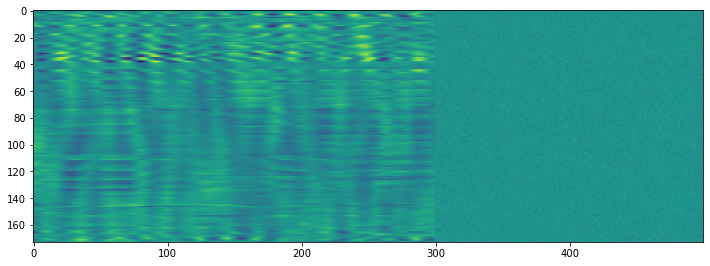

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(in_valid[3][0].to('cpu').detach().numpy())

<matplotlib.image.AxesImage>

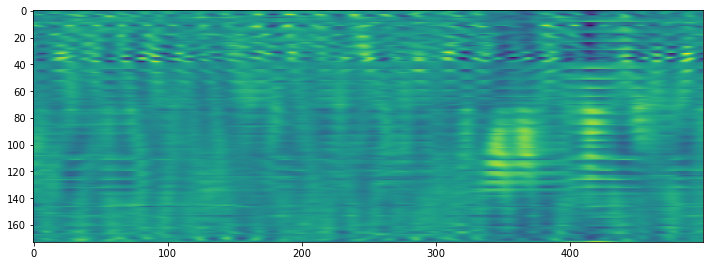

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(true_valid[3][0].to('cpu').detach().numpy())

<matplotlib.image.AxesImage>

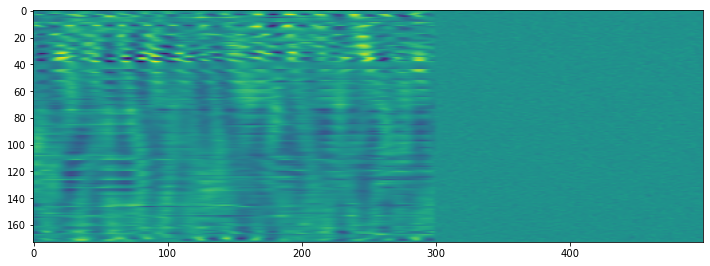

In [ ]:
plt.figure(figsize=(12,6))
plt.imshow(pred_valid[3][0].to('cpu').detach().numpy())